In [2]:
import tensorflow as tf
def generate_fgsm(image, model, epsilon):
    # Ensure the image has the correct shape (e.g., [1, 32, 32, 3] for CIFAR-10)
    image = tf.convert_to_tensor(image)
    image = tf.reshape(image, (1, *image.shape))

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        target_class = tf.argmax(prediction[0])
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_class, prediction)

    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)
    perturbed_image = image + epsilon * signed_grad
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)  # Ensure pixel values are in [0, 1] range

    return perturbed_image.numpy()[0]

# Test on image from numbers dataset

1/1 [==============================] - 0s 67ms/step


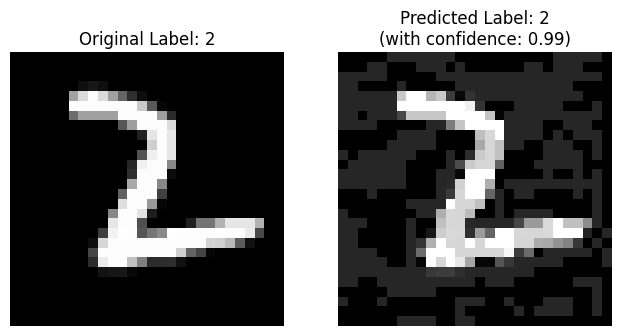

In [17]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the FCN model you created earlier
fcn_model = tf.keras.models.load_model("../Models/Mnist/mnist_model_2LFCN.karas")

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0  # Preprocess the data

# Select a random image from the test dataset
random_index = np.random.randint(0, len(test_images))
input_image = test_images[random_index]
original_label = test_labels[random_index]

# Define an epsilon value for the FGSM attack
epsilon = 0.15

# Use the generate_fgsm function to generate a perturbed image
perturbed_image = generate_fgsm(input_image, fcn_model, epsilon)

# Calculate the difference between the original and perturbed images
difference_image = input_image - perturbed_image

# Perform inference on the perturbed image
perturbed_image_reshaped = perturbed_image.reshape(1, 28, 28)  # Reshape to match the model's input shape
predictions = fcn_model.predict(perturbed_image_reshaped)

# Get the predicted class label
predicted_label = np.argmax(predictions)
confidence = np.max(predictions)

# Display the original image, perturbed image, and the difference
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(input_image, cmap='gray')
plt.title(f'Original Label: {original_label}')
plt.axis('off')

plt.subplot(132)
plt.imshow(perturbed_image_reshaped[0], cmap='gray')
plt.title(f'Predicted Label: {predicted_label}\n(with confidence: {confidence:.2f})')
plt.axis('off')

plt.show()

In [4]:
import tensorflow as tf
import numpy as np

# Load the fully connected model
fully_connected_model = tf.keras.models.load_model("../Models/MNIST/mnist_model_2LFCN.karas")
# Load the MNIST test dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0

# Evaluate the accuracy of the fully connected model with perturbed images
epsilon = 0.15  # You can adjust the epsilon value
perturbed_images = np.array([generate_fgsm(image, fully_connected_model, epsilon) for image in test_images])

# Evaluate the accuracy of the fully connected model
fully_connected_loss, fully_connected_accuracy = fully_connected_model.evaluate(perturbed_images, test_labels)
print(f"Fully Connected Model - Test Accuracy: {fully_connected_accuracy * 100:.2f}%")

313/313 [==============================] - 1s 4ms/step - loss: 1.6866 - accuracy: 0.6326
Fully Connected Model - Test Accuracy: 63.26%


In [1]:
import concurrent.futures
import tensorflow as tf
import numpy as np

# Load the fully connected model
fully_connected_model = tf.keras.models.load_model("../Models/MNIST/mnist_model_2LFCN.karas")
# Load the MNIST test dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0

# Evaluate the accuracy of the fully connected model with perturbed images
epsilon = 0.15  # You can adjust the epsilon value
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    perturbed_images = np.array(list(executor.map(lambda image: generate_fgsm(image, fully_connected_model, epsilon), test_images)))

# Evaluate the accuracy of the fully connected model
fully_connected_loss, fully_connected_accuracy = fully_connected_model.evaluate(perturbed_images, test_labels)
print(f"Fully Connected Model - Test Accuracy: {fully_connected_accuracy * 100:.2f}%")

NameError: name 'generate_fgsm' is not defined

In [4]:
from fgsm_functions import generate_fgsm
import concurrent.futures
import tensorflow as tf
import numpy as np

# Load the fully connected model
fully_connected_model = tf.keras.models.load_model("../Models/MNIST/mnist_model_2LFCN.karas")
# Load the MNIST test dataset
mnist = tf.keras.datasets.mnist
(_, _), (test_images, test_labels) = mnist.load_data()
test_images = test_images / 255.0

# Evaluate the accuracy of the fully connected model with perturbed images
epsilon = 0.15  # You can adjust the epsilon value
with concurrent.futures.ProcessPoolExecutor(max_workers=6) as executor:
    perturbed_images = np.array(list(executor.map(lambda image: generate_fgsm(image, fully_connected_model, epsilon), test_images)))

# Evaluate the accuracy of the fully connected model
fully_connected_loss, fully_connected_accuracy = fully_connected_model.evaluate(perturbed_images, test_labels)
print(f"Fully Connected Model - Test Accuracy: {fully_connected_accuracy * 100:.2f}%")

PicklingError: Can't pickle <function <lambda> at 0x00000172BEC11B20>: attribute lookup <lambda> on __main__ failed